In [20]:
from pysentimiento import create_analyzer
import pandas as pd
import matplotlib.pyplot as plt
from pysentimiento.preprocessing import preprocess_tweet
import numpy as np

df = pd.read_csv("notas.csv")

In [21]:
analyzer = create_analyzer(task="sentiment", lang="es")

def aplicar_analyzer(texto):
    resultado = analyzer.predict(texto)
    return {
        'POS': resultado.probas.get('POS', 0),  # Obtener la probabilidad de POS o 0 si no está presente
        'NEU': resultado.probas.get('NEU', 0),  # Obtener la probabilidad de NEU o 0 si no está presente
        'NEG': resultado.probas.get('NEG', 0)   # Obtener la probabilidad de NEG o 0 si no está presente
    }

C:\Users\Rodrigo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [22]:
def limpiar_comentario(comentario):
    return preprocess_tweet(comentario, lang="es")

df['nota'] = df['titulo'] + '. ' + df['bajada'] + '. ' + df['cuerpo']
df['nota_limpia'] = df['nota'].apply(limpiar_comentario)

In [23]:
df[['POS_proba', 'NEU_proba', 'NEG_proba']] = df['nota_limpia'].apply(aplicar_analyzer).apply(pd.Series)


In [42]:
df['sentimiento'] = df[['POS_proba', 'NEU_proba', 'NEG_proba']].apply(lambda x: np.argmax(x), axis=1)

# Mapear los valores de índice a etiquetas de sentimiento (POS, NEU, NEG)
sentimiento_map = {0: 'Positivo', 1: 'Neutro', 2: 'Negativo'}
df['sentimiento'] = df['sentimiento'].map(sentimiento_map)

In [40]:
# Definir la función para convertir la fecha en español a un objeto datetime
def convertir_fecha_a_datetime(fecha_en_espanol):
    meses_espanol_a_ingles = {
        'Enero': 'January', 'Febrero': 'February', 'Marzo': 'March', 'Abril': 'April',
        'Mayo': 'May', 'Junio': 'June', 'Julio': 'July', 'Agosto': 'August',
        'Septiembre': 'September', 'Octubre': 'October', 'Noviembre': 'November', 'Diciembre': 'December'
    }
    
    for mes_espanol, mes_ingles in meses_espanol_a_ingles.items():
        fecha_en_espanol = fecha_en_espanol.replace(mes_espanol, mes_ingles)
    
    formato_cadena_fecha = "%d de %B de %Y %H:%M"
    fecha_objeto = datetime.strptime(fecha_en_espanol, formato_cadena_fecha)
    
    return fecha_objeto

In [33]:
df['datetime'] = df['fecha'].apply(convertir_fecha_a_datetime)

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_7008\2560991146.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentimiento_val'] = df['sentimiento'].map(sentiment_map)


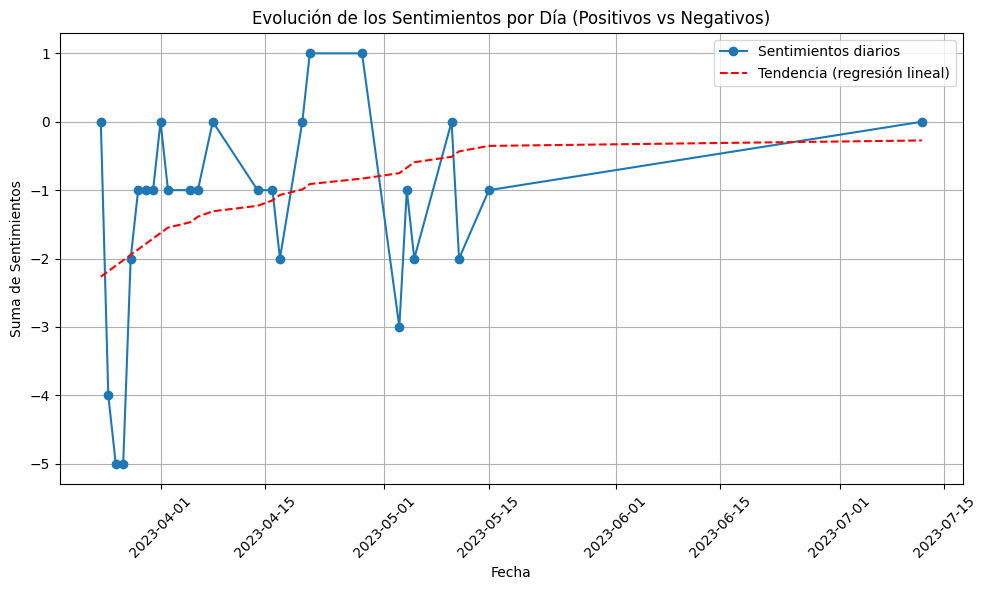

In [46]:
df['datetime'] = df['fecha'].apply(convertir_fecha_a_datetime)

# Filtrar los datos para mantener solo los registros desde marzo de 2023
df = df[(df['datetime'] >= '2023-03-01') & (df['datetime'] <= '2023-07-31')]


# Asignar valores numéricos a los sentimientos
sentiment_map = {'Positivo': 1, 'Negativo': -1, 'Neutro': 0}
df['sentimiento_val'] = df['sentimiento'].map(sentiment_map)

# Calcular la suma de los sentimientos por día
sentimientos_diarios = df.groupby(df['datetime'].dt.date)['sentimiento_val'].sum()

# Convertir las fechas a números para la regresión
dates = np.array(sentimientos_diarios.index)
dates_num = np.arange(len(dates))

# Calcular los coeficientes de la regresión lineal
coefficients = np.polyfit(dates_num, sentimientos_diarios.values, 1)
trend = np.poly1d(coefficients)

# Graficar la evolución de los sentimientos en el tiempo por día
plt.figure(figsize=(10, 6))
plt.plot(dates, sentimientos_diarios, marker='o', label='Sentimientos diarios')
plt.plot(dates, trend(dates_num), label='Tendencia (regresión lineal)', linestyle='--', color='red')
plt.title('Evolución de los Sentimientos por Día (Positivos vs Negativos)')
plt.xlabel('Fecha')
plt.ylabel('Suma de Sentimientos')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()